In [42]:
#import necessary librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC #efficient on small DFs
import seaborn as sns

In [2]:
#display all columns
pd.set_option('display.max_column', 21)

In [3]:
#import the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Worflow process
>#### Objective
>+ Predict if a customer will churn based on the services they pay for and their personal informations.
>+ Metrics: 1- Accuracy? 2- Precision? 3-Recall? 4-F1-Score? ---> (We can retrieve all these matrix from the confusion metrics.)

#### 1 - EDA
>##### Analysis of the form
+ Identification of the target variable: Churn
+ Number of rows and columns: 7043 rows, 21 columns
+ Type of the variables: 18 objects, 2 int64, 1 float64
+ NaNs (if any): No NaN

>##### Substantive analysis
+ Visualizing the target: 26.5% churn and 73.5% not churn
+ Understand the different variables
+ Visualization the relation between the features and the target variable
+ Identification of outliers

In [5]:
df1 = df.copy()

In [6]:
df1.shape

(7043, 21)

<AxesSubplot:ylabel='None'>

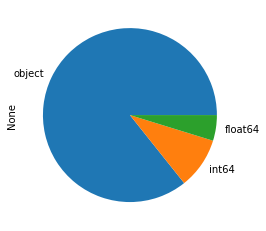

In [7]:
#just for fun, not necessary
df1.dtypes.value_counts().plot.pie()

<AxesSubplot:>

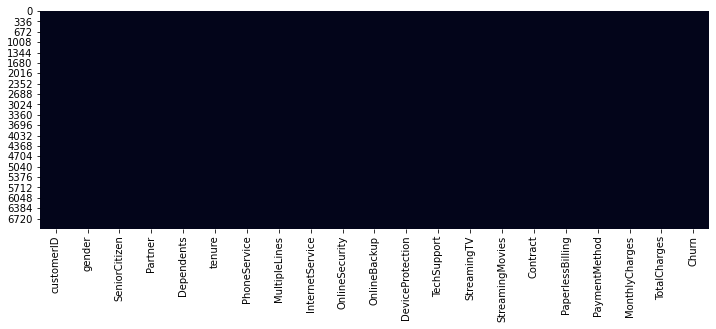

In [8]:
#lookig for NaNs
plt.figure(figsize=(12,4))
sns.heatmap(df1.isna(), cbar=False)

In [9]:
#convert total charges to float
df1.TotalCharges = df1.TotalCharges.apply(lambda x: 0 if x == ' ' else x)
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [10]:
#Analyzing the target
#We can easily state that our classes are not balanced for this specific task. We might need to use a metric such as
# the accuracy, F1-Score or Recall
df1.Churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

<Figure size 432x288 with 0 Axes>

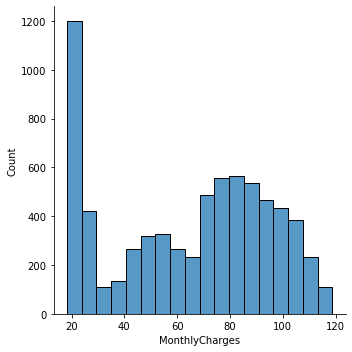

<Figure size 432x288 with 0 Axes>

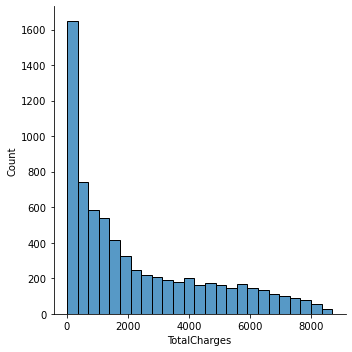

In [11]:
#Histogram with continuous variables
for col in df1.select_dtypes('float'):
    plt.figure()
    sns.displot(df1[col])

## Pre-Processing

>##### Just before we get into feature selection process, normalization, or dealing with outliers, we will create a simple model, evaluate it then perform the diagnosis in order to gradually improve it. For instance, if the model is on overfitting, we will try the feature selection process to improve it, etc..

In [12]:
data = df.copy()

In [13]:
data.TotalCharges = data.TotalCharges.apply(lambda x: 0 if x == ' ' else x)
data.TotalCharges = pd.to_numeric(data.TotalCharges)

In [14]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Train Test - Encoding - Cleaning

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#use train_test_split to split the DF into 2
trainset, testset = train_test_split(data, test_size = 0.2, random_state=0)

In [17]:
trainset.Churn.value_counts()

No     4133
Yes    1501
Name: Churn, dtype: int64

In [18]:
#We make sure not to perfom any manipulation on the test set, we don't touch it!
testset.Churn.value_counts()

No     1041
Yes     368
Name: Churn, dtype: int64

### Encoding

In [19]:
code = {'Yes': 1, 'No': 0, 'No internet service':-1, 'Male':1, 'Female':2,'DSL':1, 'Fiber optic':2,\
               'Month-to-month':0, 'One year':1, 'Two year':2,\
               'Electronic check':0, 'Mailed check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}

In [20]:
#replace all categorical features with numerical values prior to creating our model
for col in data.select_dtypes('object'):
    data[col] = data[col].map(code)

In [21]:
#Remove columns with NaNs after encoding
data = data.dropna(axis=1, how='any')

### Basic modelization for pre-processing

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [23]:
model = DecisionTreeClassifier(random_state=0)

##### Evaluation process
>##### We will prioritize the recall metric because we are interested in predicting the number of customers who are likely to churn based the features. The recall shows us how many customers that churned that we predicted correctly and incorrectly.

In [24]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [25]:
#retrieve the X(features) and the y(target variable) from the data set
y = data.Churn
X = data.drop(['Churn'], axis=1)

In [26]:
#Divide the data into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

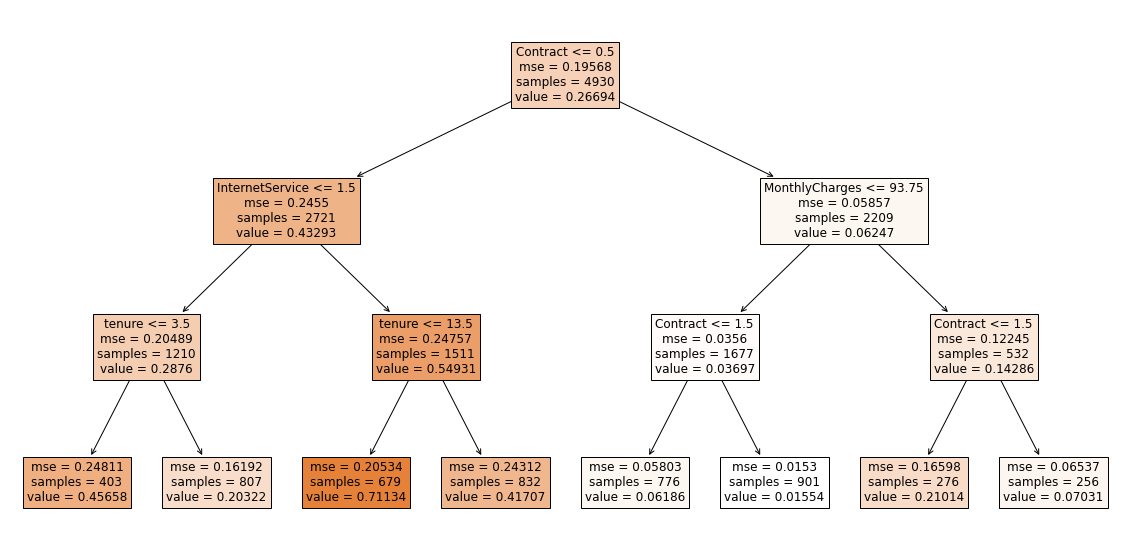

In [27]:
#Display the Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=100)
dt.fit(X_train, y_train)
plot_tree(dt, feature_names=list(X_train.columns), precision=5, 
           filled=True, fontsize=12, impurity=True);

In [28]:
def evaluation(model):
    """This fuction fit the train set to the model, predict on the test set then plot the train score and val score"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Confusion Matirix: \n', confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=6, scoring='f1',\
                                          train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(10,4))
    plt.plot(N, train_score.mean(axis=1), label='Train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.title(model)

Confusion Matirix: 
 [[1266  294]
 [ 284  269]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1560
           1       0.48      0.49      0.48       553

    accuracy                           0.73      2113
   macro avg       0.65      0.65      0.65      2113
weighted avg       0.73      0.73      0.73      2113



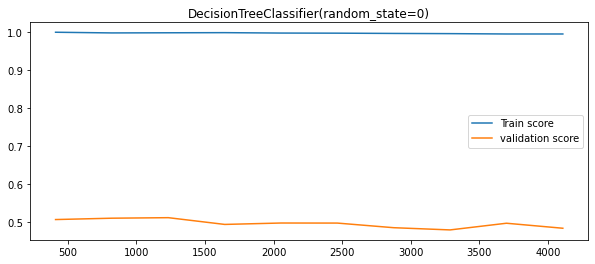

In [29]:
evaluation(model)

>##### When computing the confusion matrix we can see that on 1560 customers who don't churn we correctly predict 1266 (Recall = 81%) and incorectly predict 294. On those who churned, we correctly predict 269 out of 553 (Recall = 49%) and incorrectly predict 284.

>##### When looking at the plot above, we can quickly see that our model is on OVERFITTING. It has a score of 100% on the train set but when it comes to data it hasn't seen before, (validation set) the score is not that good. As a solution to overfitting, we can try feature selection in order to improve our model. 

In [30]:
#count the number of different types of our converted data set
data.dtypes.value_counts()

int64      17
float64     2
dtype: int64

In [31]:
#display a displot of the catagorical features after conversion
for col in data.select_dtypes('int'):
    sns.displot(data[col])

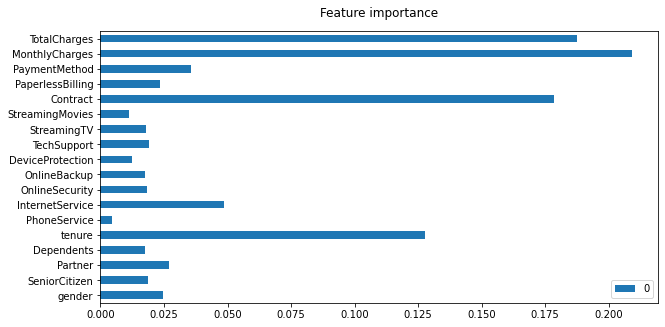

In [32]:
#displat the importance of each feature in a bar plot (prior to feature selection)
pd.DataFrame(model.feature_importances_, index=X_train.columns).plot(kind='barh', figsize=(10,5))
plt.title('Feature importance', y=1.03)
plt.legend()

>##### As a first step to deal with the overfitting, we are going to use the selector KBest for feature selection. We paly with different values for "K" and re get a better training for our data with k = 3, which returns a recall of 88% not churned and 54% churned. This is only for the DecisionTreeClassifier (see below)

In [33]:
#using KBest selector 
model = make_pipeline(SelectKBest(f_classif, k=3), DecisionTreeClassifier(random_state=0))

Confusion Matirix: 
 [[1368  192]
 [ 256  297]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1560
           1       0.61      0.54      0.57       553

    accuracy                           0.79      2113
   macro avg       0.72      0.71      0.71      2113
weighted avg       0.78      0.79      0.78      2113



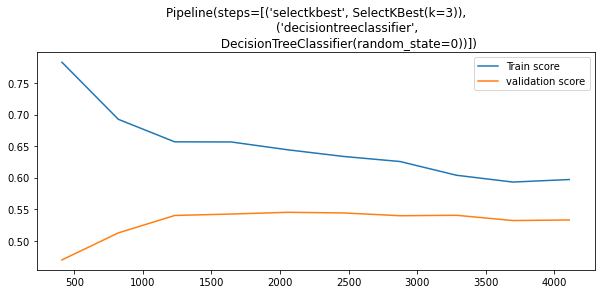

In [34]:
#re-evaluate the model to see its performance
evaluation(model)

## Modelization
##### Chosing three different models to test our data set, including 2 tree-based models.
>+ ADABoost: Like its name mentioned it, ADABoost is used to boost the performance of decision trees on binary classification problems. So, we choose it so we can use its hyperparameters in case our model is difficult to train.
+SVM: Besides the fact SVM works very well with medium and small data sets, it also helps capture much more complex relationships between your datapoints without having to perform difficult transformations on your own.
+LogisticRegression: We use the logisticRegression model because it is a suitable model when our target variable contains two possible labels. 
##### We choose the model with the best recall for the churned label because we are mainly interested in predicting the customers who are likely to churned based on the features with the best correlation with the target variable. (see process below)

In [35]:
# #define a dict containg our 3 models including the basic model we chose for pre-processing purpose
# from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [36]:
#define a preprocessor for our model where we can play with the k parameter to select the KBest features
preprocessor = make_pipeline(SelectKBest(f_classif, k=13))

In [48]:
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
logreg = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(random_state=0))
ADABoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))

In [49]:
#dictionary containing our models
dict_of_models = {'SVM':SVM, 'LogisticRegression':logreg,\
                  'AdaBoostClassifier': ADABoost}

SVM
Confusion Matirix: 
 [[1420  140]
 [ 292  261]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1560
           1       0.65      0.47      0.55       553

    accuracy                           0.80      2113
   macro avg       0.74      0.69      0.71      2113
weighted avg       0.78      0.80      0.78      2113

LogisticRegression
Confusion Matirix: 
 [[1403  157]
 [ 255  298]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1560
           1       0.65      0.54      0.59       553

    accuracy                           0.81      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113

AdaBoostClassifier
Confusion Matirix: 
 [[1412  148]
 [ 260  293]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1560
           1       0.66      0.53      0.59       5

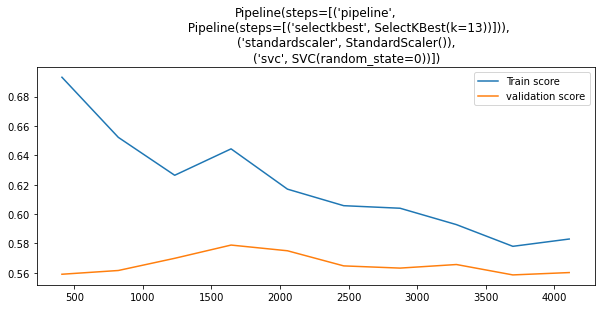

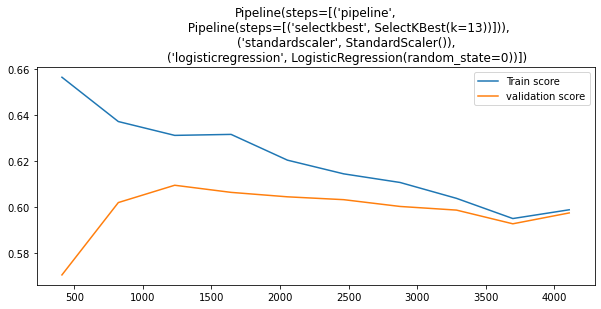

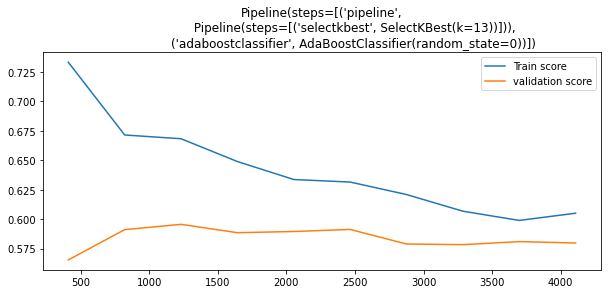

In [50]:
#loop through our models the evaluation each one of them with our function "evaluation"
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

>##### From the three models selected, we will choose the logisticRegression model since it has the best recall score.